In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import data

In [2]:
data = pd.read_csv('../data/num_file/min_10/p040.csv')

In [3]:
print(data)

                  datetime  count
0      2022-04-21 01:40:00    200
1      2022-04-21 01:50:00    833
2      2022-04-21 02:00:00     65
3      2022-04-21 02:10:00      0
4      2022-04-21 02:20:00      0
...                    ...    ...
19495  2022-09-03 10:50:00   4034
19496  2022-09-03 11:00:00   3556
19497  2022-09-03 11:10:00   1082
19498  2022-09-03 11:20:00   3937
19499  2022-09-03 11:30:00   4176

[19500 rows x 2 columns]


If there is no people, use NaN.

In [4]:
data.loc[data['count']==0, 'count'] = np.NaN

In [5]:
print(data)

                  datetime   count
0      2022-04-21 01:40:00   200.0
1      2022-04-21 01:50:00   833.0
2      2022-04-21 02:00:00    65.0
3      2022-04-21 02:10:00     NaN
4      2022-04-21 02:20:00     NaN
...                    ...     ...
19495  2022-09-03 10:50:00  4034.0
19496  2022-09-03 11:00:00  3556.0
19497  2022-09-03 11:10:00  1082.0
19498  2022-09-03 11:20:00  3937.0
19499  2022-09-03 11:30:00  4176.0

[19500 rows x 2 columns]


<Axes: >

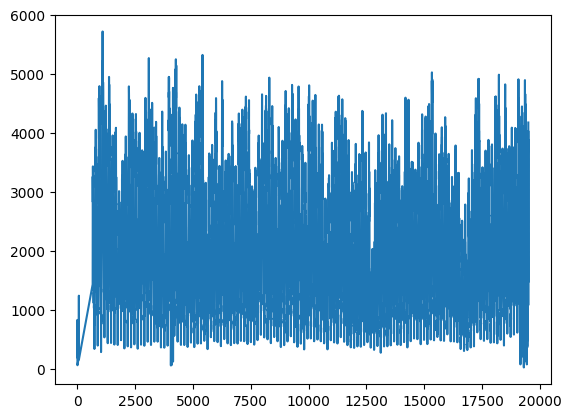

In [6]:
data['count'] = data['count'].interpolate(method='linear')
data['count'].plot()

## Normalize data

<Axes: >

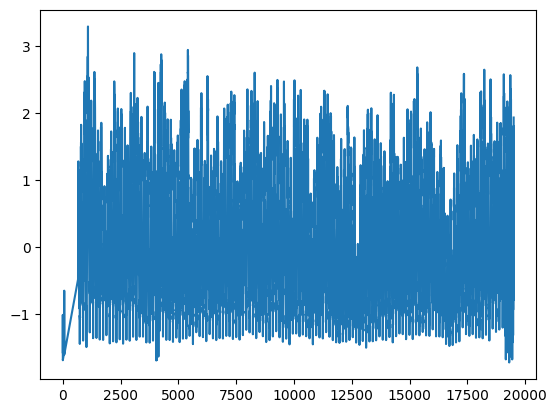

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['count'] = scaler.fit_transform(data[['count']])
data['count'].plot()

In [8]:
print(data)

                  datetime     count
0      2022-04-21 01:40:00 -1.563824
1      2022-04-21 01:50:00 -1.007215
2      2022-04-21 02:00:00 -1.682532
3      2022-04-21 02:10:00 -1.680572
4      2022-04-21 02:20:00 -1.678611
...                    ...       ...
19495  2022-09-03 10:50:00  1.807486
19496  2022-09-03 11:00:00  1.387171
19497  2022-09-03 11:10:00 -0.788265
19498  2022-09-03 11:20:00  1.722192
19499  2022-09-03 11:30:00  1.932349

[19500 rows x 2 columns]


In [9]:
encode_input_data = []
decode_input_data = []
decode_output_data = []
time_step = 10

for i in range(len(data)-time_step-1):
    encode_input_data.append(data['count'].values[i:i+time_step])
    decode_input_data.append(data['count'].values[i:i+time_step])
    decode_output_data.append(data['count'].values[i+1:i+time_step+1])

encode_input_data = np.array(encode_input_data)
decode_input_data = np.array(decode_input_data)
decode_output_data = np.array(decode_output_data)

In [10]:
encode_input_data = encode_input_data.reshape(encode_input_data.shape[0], encode_input_data.shape[1], 1)
decode_input_data = decode_input_data.reshape(decode_input_data.shape[0], decode_input_data.shape[1], 1)
decode_output_data = decode_output_data.reshape(decode_output_data.shape[0], decode_output_data.shape[1], 1)

In [11]:
train_size = int(len(encode_input_data)*0.8)
encode_input_data_train = encode_input_data[:train_size]
decode_input_data_train = decode_input_data[:train_size]
decode_output_data_train = decode_output_data[:train_size]
encode_input_data_test = encode_input_data[train_size:]
decode_input_data_test = decode_input_data[train_size:]
decode_output_data_test = decode_output_data[train_size:]

## Model

In [12]:
from keras.layers import Input, LSTM, BatchNormalization, RepeatVector, TimeDistributed, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [13]:
input_train = Input(shape=(time_step, 1))
output_train = Input(shape=(time_step, 1))

In [14]:
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(32, activation='relu', return_sequences=False, return_state=True)(input_train)

2024-03-30 07:50:53.045761: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-30 07:50:53.045780: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-30 07:50:53.045784: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-30 07:50:53.045803: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-30 07:50:53.045814: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
encoder_last_h1 = BatchNormalization()(encoder_last_h1)
encoder_last_c = BatchNormalization()(encoder_last_c)

In [16]:
decoder = RepeatVector(time_step)(encoder_last_h1)
decoder = LSTM(32, activation='relu', return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

In [17]:
out = TimeDistributed(Dense(time_step))(decoder)

In [18]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 32),      │      4,352 │ input_layer[0][0] │
│                     │ (None, 32),       │            │                   │
│                     │ (None, 32)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32)        │        128 │ lstm[0][0]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 10, 32)    │          0 │ batch_normalizat… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ lstm[0][2]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 10, 32)    │      8,320 │ repeat_vector[0]… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 10, 10)    │        330 │ lstm_1[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,258 (51.79 KB)

 Trainable params: 13,130 (51.29 KB)

 Non-trainable params: 128 (512.00 B)

In [20]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es])

Epoch 1/100


2024-03-30 07:51:06.083729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - loss: 0.1737 - mae: 0.2849 - val_loss: 0.2796 - val_mae: 0.4559
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 177ms/step - loss: 0.0415 - mae: 0.1487 - val_loss: 0.2009 - val_mae: 0.3854
Epoch 3/100
 35/110 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - loss: 0.0402 - mae: 0.1478